In [1]:
import pandas as pd     # Se carga la Libreria de pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
sns.set(style="darkgrid")
sns.set(font_scale=0.9)
pd.options.mode.copy_on_write = True


In [2]:
df_lesiones= pd.read_excel('data/lesiones.xlsx', sheet_name=None)

In [3]:
print(df_lesiones.keys())

dict_keys(['HECHOS', 'DICCIONARIO_HECHOS', 'VICTIMAS', 'DICCIONARIO_VICTIMAS'])


In [128]:
df_hechos_lesiones= df_lesiones['HECHOS'].copy()               # Se carga el dataset de "Hechos de Lesiones"
df_victimas_lesiones= df_lesiones['VICTIMAS'].copy()           # Se carga el dataset de "Victimas de Lesiones"

In [5]:
# Se carga el mapa de Buenos Aires
url_caba = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson"
gdf_caba = gpd.read_file(url_caba)

#### `Analisis del dataSet "Hechos_Lesionados"`

In [129]:
df_hechos_lesiones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23785 entries, 0 to 23784
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     23785 non-null  object 
 1   n_victimas             23785 non-null  int64  
 2   aaaa                   23785 non-null  int64  
 3   mm                     23785 non-null  int64  
 4   dd                     23785 non-null  int64  
 5   fecha                  23785 non-null  object 
 6   hora                   23785 non-null  object 
 7   franja_hora            23780 non-null  object 
 8   direccion_normalizada  23732 non-null  object 
 9   comuna                 23616 non-null  object 
 10  tipo_calle             23785 non-null  object 
 11  otra_direccion         23785 non-null  object 
 12  calle                  12867 non-null  object 
 13  altura                 12771 non-null  float64
 14  cruce                  9407 non-null   object 
 15  ge

In [130]:
df_hechos_lesiones.head(3)

,id,n_victimas,aaaa,mm,dd,fecha,hora,franja_hora,direccion_normalizada,comuna,...,latutid,victima,acusado,participantes,moto,auto,transporte_publico,camion,ciclista,gravedad
0,LC-2019-0000179,1,2019,1,1,2019-01-01 00:00:00,09:00:00,9,SD,14,...,-34.559658,CICLISTA,SD,CICLISTA-SD,SD,SD,SD,SD,x,SD
1,LC-2019-0000053,1,2019,1,1,2019-01-01 00:00:00,01:55:00,1,SD,8,...,-34.669125,AUTO,SD,AUTO-SD,SD,x,SD,SD,SD,SD
2,LC-2019-0000063,1,2019,1,1,2019-01-01 00:00:00,02:00:00,2,SD,8,...,-34.677556,SD,SD,SD-SD,SD,SD,SD,SD,SD,SD


##### Analizando el contenido de las columnas se pudo observar que: 
1. Varias columnas continen la misma informacion como "direccion_normalizada, otra direccion, calle"
2. Las columnas "calle, altura, cruce, geocodificacion_CABA" no son necesarias para este analisis
3. Las columnas "moto, auto, transporte_publico, camion, ciclista" solo muestran cuales son los tipos de transporte involucrados (acusado, victima)
4. El nombre de la columna "latutid" esta mal escrito
5. Las columnas "aaaa, mm, dd" no son necesarios para este analisis

Por lo tanto todas estan culumnas seran eliminadas el dataset y tambien se modificara el nombre de la columna "latutid" y "id"

In [131]:
# Eliminar columnas innecesarias
df_hechos_lesiones= df_hechos_lesiones.drop(['aaaa','mm','dd','franja_hora','direccion_normalizada','otra_direccion','calle','altura','cruce',
                                             'geocodificacion_CABA','moto','auto','transporte_publico','camion','ciclista', 'franja_hora'], axis=1) 
# cambiar normbre de las columnas
df_hechos_lesiones= df_hechos_lesiones.rename(columns={'id': 'Id_hecho', 'latutid': 'latitud'}) 

In [132]:
df_hechos_lesiones[~df_hechos_lesiones['fecha'].astype(str).str.startswith('20')]

,Id_hecho,n_victimas,fecha,hora,comuna,tipo_calle,longitud,latitud,victima,acusado,participantes,gravedad
23784,LC-2020-0244615,1,5/17/2020,21:00:00,SD,SD,-5829963273,-3472890716,MOTO,AUTO,MOTO-AUTO,SD


- Se detecta de un valor de fecha tiene un formato incorrecto y se procede a corregirla

In [133]:
df_hechos_lesiones.loc[df_hechos_lesiones['fecha'] == '5/17/2020','fecha'] = '2020-05-17'

- Se cambia el tipo de la columna fecha a 'date'

In [134]:
df_hechos_lesiones['fecha']= pd.to_datetime(df_hechos_lesiones['fecha'])

- Se comprueba que la columna 'hora' tenga registro con "SD"

In [135]:
df_hechos_lesiones[df_hechos_lesiones['hora'].isin(['sd', 'SD'])]

,Id_hecho,n_victimas,fecha,hora,comuna,tipo_calle,longitud,latitud,victima,acusado,participantes,gravedad
1462,PFA-2019-0000120,1,2019-02-26,SD,NaN,SD,NaN,NaN,SD,SD,SD-SD,SD
9039,PFA-2019-0000301,1,2019-11-04,SD,NaN,SD,NaN,NaN,SD,SD,SD-SD,SD
9928,PNA-2019-0005246,0,2019-12-20,SD,NaN,SD,NaN,NaN,SD,SD,SD-SD,SD
17372,LC-2021-0038668,1,2021-01-26,sd,SD,CALLE,SD,SD,MOTO,AUTO,MOTO-AUTO,GRAVE
17916,LC-2021-0098397,1,2021-03-04,sd,SD,AVENIDA,SD,SD,PEATON,AUTO,PEATON-AUTO,GRAVE
17947,LC-2021-0100636,1,2021-03-05,sd,SD,AVENIDA,SD,SD,PEATON,AUTO,PEATON-AUTO,GRAVE
18603,LC-2021-0166702,1,2021-04-10,sd,SD,CALLE,SD,SD,AUTO,OBJETO FIJO,AUTO-OBJETO FIJO,GRAVE
18975,LC-2021-0208169,1,2021-05-06,sd,SD,CALLE,SD,SD,MOTO,AUTO,MOTO-AUTO,SD
20916,LC-2021-0448511,1,2021-08-23,SD,SD,SD,SD,SD,SD,SD,SD-SD,SD


Se le pone una formato de hora a los registros con 'SD'

In [136]:
df_hechos_lesiones.loc[df_hechos_lesiones['hora'].isin(['sd', 'SD']),'hora'] = '00:00:00'

- Se filtran los registros que tienen 'a.m.' y 'p.m.' en la hora

In [137]:
df_hechos_lesiones[df_hechos_lesiones['hora'].astype(str).str.contains('a.m.')].head(3)

,Id_hecho,n_victimas,fecha,hora,comuna,tipo_calle,longitud,latitud,victima,acusado,participantes,gravedad
10076,LC-2020-0004057,1,2020-01-03,03:20:00 a.m.,15,CALLE,-58.445753737126,-34.600574687554,CICLISTA,AUTO,CICLISTA-AUTO,SD
10081,LC-2020-0006530,1,2020-01-04,09:55:00 a.m.,14,AVENIDA,-58.408319471806,-34.586545585325,CICLISTA,SD,CICLISTA-SD,SD
10084,LC-2020-0009835,1,2020-01-06,10:10:00 a.m.,1,CALLE,-58.388392381074,-34.624937924803,CICLISTA,CAMIONETA,CICLISTA-CAMIONETA,SD


In [138]:
df_hechos_lesiones[df_hechos_lesiones['hora'].astype(str).str.contains('p.m.')].head(3)

,Id_hecho,n_victimas,fecha,hora,comuna,tipo_calle,longitud,latitud,victima,acusado,participantes,gravedad
10073,LC-2020-0002346,1,2020-01-02,01:00:00 p.m.,2,AVENIDA,-58.389203129482,-34.587646270159,CICLISTA,AUTO,CICLISTA-AUTO,SD
10074,LC-2020-0003142,1,2020-01-02,04:15:00 p.m.,3,CALLE,-58.404492539573,-34.608216527535,CICLISTA,AUTO,CICLISTA-AUTO,SD
10075,LC-2020-0003360,1,2020-01-02,05:10:00 p.m.,14,AVENIDA,-58.431561455891,-34.576609010579,CICLISTA,SD,CICLISTA-SD,SD


- Se procede a cambiar el formato de hora a los registros que tienen 'p.m.'

In [139]:
filtro= df_hechos_lesiones['hora'].astype(str).str.contains('a.m.')
df_hechos_lesiones.loc[filtro, 'hora'] = pd.to_datetime(df_hechos_lesiones.loc[filtro, 'hora'], format='%H:%M:%S a.m.').dt.time
filtro= df_hechos_lesiones['hora'].astype(str).str.contains('p.m.')
df_hechos_lesiones.loc[filtro, 'hora'] = pd.to_datetime(df_hechos_lesiones.loc[filtro, 'hora'], format='%H:%M:%S p.m.').dt.time

In [140]:
df_hechos_lesiones.isnull().sum()

Id_hecho           0
n_victimas         0
fecha              0
hora               0
comuna           169
tipo_calle         0
longitud         262
latitud          262
victima            0
acusado            0
participantes      0
gravedad           0
dtype: int64

#### Se puede observar que hay columnas comuna, longitud. latitud, direccion y franja_hora tienes valores nulos.

In [141]:
df_hechos_lesiones[df_hechos_lesiones['comuna'].isnull()].head(3)

,Id_hecho,n_victimas,fecha,hora,comuna,tipo_calle,longitud,latitud,victima,acusado,participantes,gravedad
252,LC-2019-0687058,1,2019-01-11,09:20:00,NaN,SD,NaN,NaN,SD,SD,SD-SD,SD
253,LC-2019-0688515,1,2019-01-11,16:58:00,NaN,SD,NaN,NaN,SD,SD,SD-SD,SD
274,LC-2019-0757409,1,2019-01-12,06:45:00,NaN,SD,NaN,NaN,SD,SD,SD-SD,SD


#### Al filtrar los valores nulos de la columna "comuna" se puede notar tambien tiene valoresde longitud y latitud, por lo tanto no nos sirven para nuestra analisis

In [142]:
df_hechos_lesiones= df_hechos_lesiones.dropna(subset=['comuna']) # Elimina filas con comuna nulas
df_hechos_lesiones= df_hechos_lesiones.dropna(subset=['longitud']) # Elimina filas con comuna nulas

In [143]:
df_hechos_lesiones.isnull().sum()

Id_hecho         0
n_victimas       0
fecha            0
hora             0
comuna           0
tipo_calle       0
longitud         0
latitud          0
victima          0
acusado          0
participantes    0
gravedad         0
dtype: int64

In [144]:
df_hechos_lesiones['longitud'].value_counts() # Contar los valores

longitud
SD                  1209
-58.500738109269      40
-58.380998330204      35
-58.382233829418      29
-58.500649            27
                    ... 
-58.514577             1
-58.433752             1
-58.44362              1
-58.472563             1
-5829963273            1
Name: count, Length: 13810, dtype: int64

#### Se observan que day coordenadas a las cuales no tienen el "." Se buscaran estos valores y se le colocara el "."

In [145]:
def  insertar_punto(coordenada):
    coordenada= str(coordenada)
    if len(coordenada)> 2:
        if coordenada[3] != ".":
            coordenada = coordenada[:3] + '.' + coordenada[3:]
    return coordenada

In [146]:
# Insertar el "." en la coordenadas para poder graficarlas
df_hechos_lesiones['longitud']= df_hechos_lesiones['longitud'].apply(insertar_punto)
df_hechos_lesiones['latitud']= df_hechos_lesiones['latitud'].apply(insertar_punto)

In [147]:
df_hechos_lesiones.tail(5)

,Id_hecho,n_victimas,fecha,hora,comuna,tipo_calle,longitud,latitud,victima,acusado,participantes,gravedad
23780,LC-2021-0652849,1,2021-12-31,19:30:00,9,AVENIDA,-58.513477158887,-34.659713573880,SD,SD,SD-SD,SD
23781,LC-2021-0652865,2,2021-12-31,19:40:00,9,AVENIDA,-58.488326609395,-34.641753304864,SD,SD,SD-SD,SD
23782,LC-2021-0652907,1,2021-12-31,20:00:00,1,SD,-58.382894,-34.583083,SD,SD,SD-SD,SD
23783,LC-2021-0652921,1,2021-12-31,22:00:00,5,CALLE,-58.414532050899,-34.614288229345,MOTO,TRANSPORTE PUBLICO,MOTO-TRANSPORTE PUBLICO,GRAVE
23784,LC-2020-0244615,1,2020-05-17,21:00:00,SD,SD,-58.29963273,-34.72890716,MOTO,AUTO,MOTO-AUTO,SD


Se grafica las columnas "victima, acusado, gravedad" para ver si hay datos iguales escritos en minisculas o mayusculas

C:\Users\Familia Velazco\AppData\Local\Temp\ipykernel_1776\1018552528.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation= 35)
C:\Users\Familia Velazco\AppData\Local\Temp\ipykernel_1776\1018552528.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation= 35)
C:\Users\Familia Velazco\AppData\Local\Temp\ipykernel_1776\1018552528.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation= 35)
C:\Users\Familia Velazco\AppData\Local\Temp\ipykernel_1776\1018552528.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator

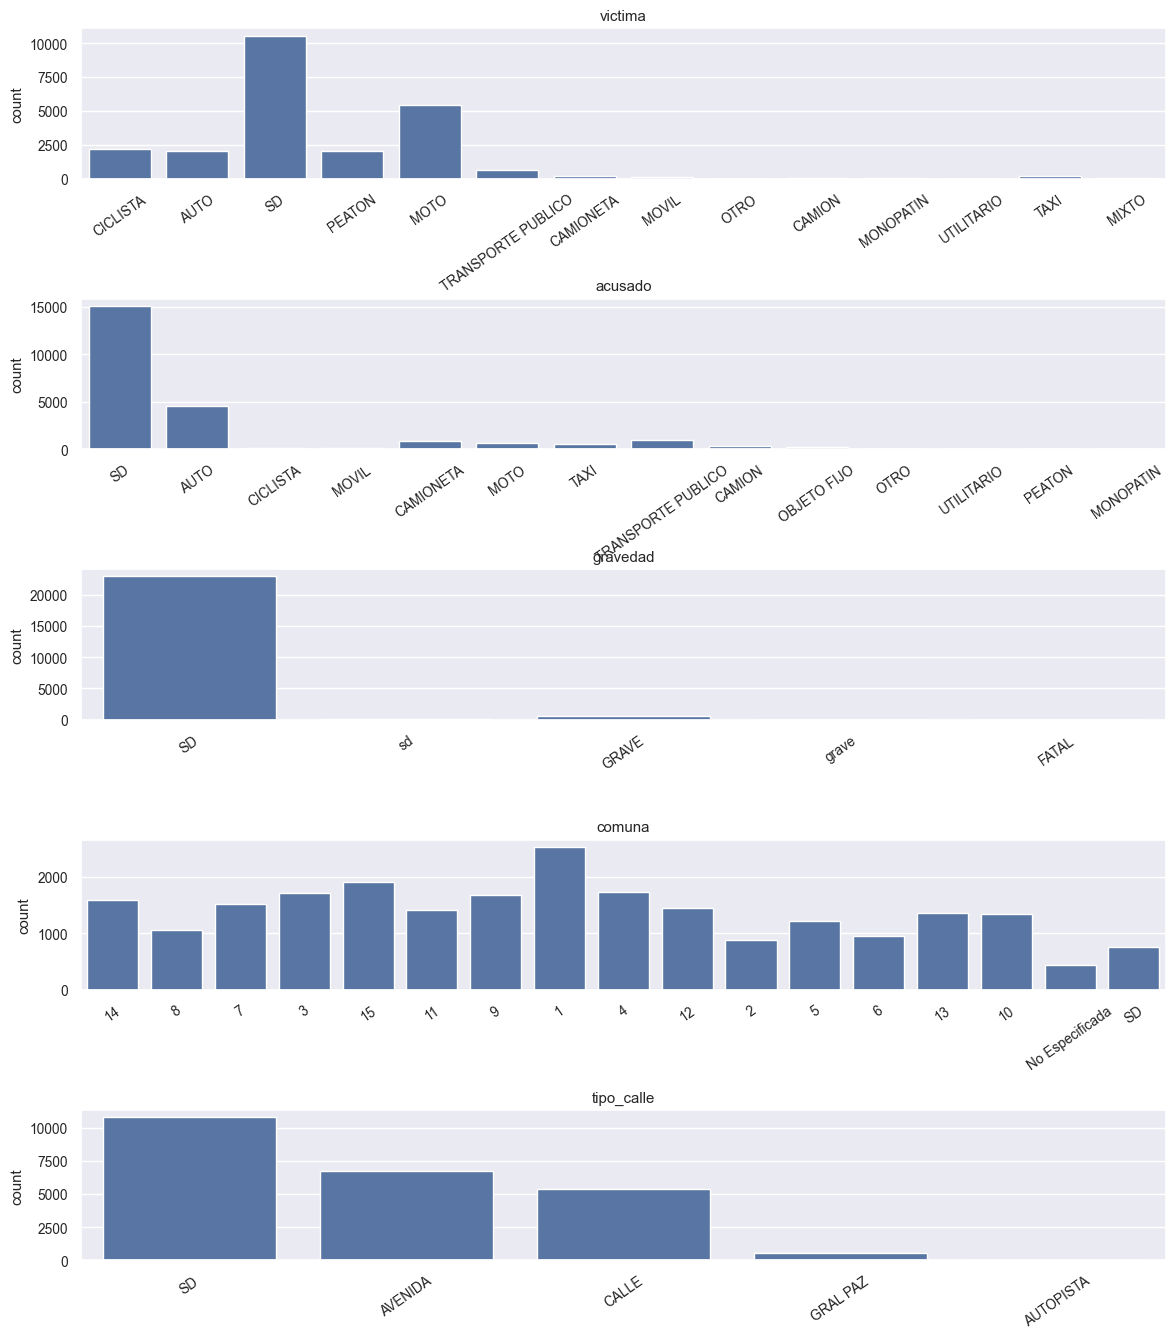

In [148]:
columnas= ['victima', 'acusado', 'gravedad','comuna', 'tipo_calle']
fig, ax = plt.subplots(nrows= 5, ncols= 1, figsize= (14,16))
fig.subplots_adjust(hspace= 0.8)
for i, col in enumerate(columnas):
    sns.countplot(data=df_hechos_lesiones, x= col, ax= ax[i])
    ax[i].set_title(col)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation= 35)

Observaciones:
1. La mayoria de las columnas tiene valores "SD" lo que siginifica que no se registraron esos datos en ese accidente

Se Cambiaran todo los valores donde aparezca "SD" por "SIN DATO"

In [149]:
columnas= ['comuna', 'tipo_calle', 'longitud', 'latitud', 'victima', 'acusado', 'participantes', 'gravedad']
for col in columnas:
    df_hechos_lesiones.loc[df_hechos_lesiones[col].isin(['sd', 'SD', 'No Especificada']), col] = 'SIN DATO'
df_hechos_lesiones['participantes'] = df_hechos_lesiones['victima']+ ' - '+ df_hechos_lesiones['acusado']

In [150]:
# Se ponen todos los datos sd y gravedad en mayusculas
df_hechos_lesiones.loc[df_hechos_lesiones['gravedad'] == 'grave','gravedad'] = 'GRAVE'

In [151]:
df_hechos_lesiones.head()

,Id_hecho,n_victimas,fecha,hora,comuna,tipo_calle,longitud,latitud,victima,acusado,participantes,gravedad
0,LC-2019-0000179,1,2019-01-01,09:00:00,14,SIN DATO,-58.408911,-34.559658,CICLISTA,SIN DATO,CICLISTA - SIN DATO,SIN DATO
1,LC-2019-0000053,1,2019-01-01,01:55:00,8,SIN DATO,-58.44351,-34.669125,AUTO,SIN DATO,AUTO - SIN DATO,SIN DATO
2,LC-2019-0000063,1,2019-01-01,02:00:00,8,SIN DATO,-58.468335,-34.677556,SIN DATO,SIN DATO,SIN DATO - SIN DATO,SIN DATO
3,LC-2019-0000079,1,2019-01-01,02:30:00,7,SIN DATO,-58.437425,-34.647349,PEATON,SIN DATO,PEATON - SIN DATO,SIN DATO
4,LC-2019-0000082,4,2019-01-01,04:30:00,3,SIN DATO,-58.398225,-34.604579,AUTO,SIN DATO,AUTO - SIN DATO,SIN DATO


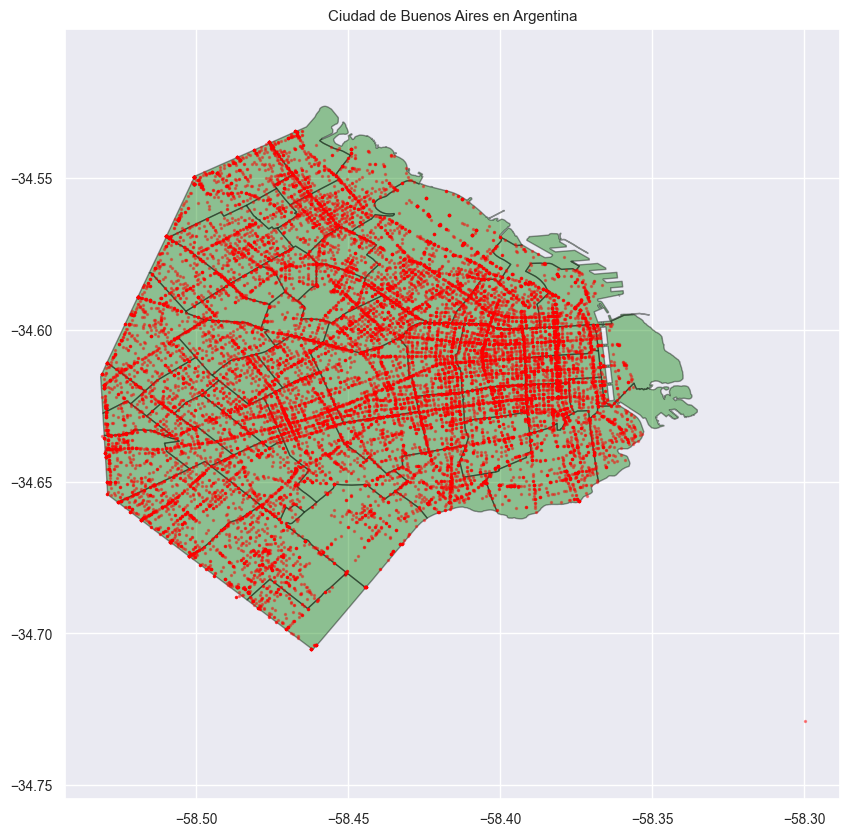

In [44]:
# Se cargan los Puntos geograficos
df_hechos_lesiones_NoSD= df_hechos_lesiones[df_hechos_lesiones['longitud']!= 'SIN DATO']
geometry = gpd.points_from_xy(df_hechos_lesiones_NoSD['longitud'], df_hechos_lesiones_NoSD['latitud'], crs="EPSG:4326")
gdf_lesionados = gpd.GeoDataFrame(df_hechos_lesiones_NoSD, geometry=geometry)

# Plotear el mapa de Argentina y la Ciudad Autónoma de Buenos Aires
fig, ax = plt.subplots(figsize=(10, 10))

gdf_caba.plot(ax=ax, color='green', edgecolor='black', alpha=0.4)
gdf_lesionados.plot(ax=ax, color='red', markersize=2, alpha=0.4)
ax.set_title('Ciudad de Buenos Aires en Argentina')
plt.axis('equal')
plt.show()

#### `Analisis del dataSet "Victimas_Lesionados"`

In [152]:
df_victimas_lesiones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27605 entries, 0 to 27604
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID hecho          27605 non-null  object        
 1   AAA               27605 non-null  int64         
 2   MM                27605 non-null  int64         
 3   DD                27605 non-null  int64         
 4   FECHA             27605 non-null  datetime64[ns]
 5   VEHICULO_VICTIMA  27605 non-null  object        
 6   SEXO              27605 non-null  object        
 7   EDAD_VICTIMA      27605 non-null  object        
 8   GRAVEDAD          27605 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 1.9+ MB


In [153]:
# cambiar de nombre algunas columnas
df_victimas_lesiones = df_victimas_lesiones.rename(columns={'VEHICULO_VICTIMA': 'VICTIMA', 'EDAD_VICTIMA':'EDAD', 'ID hecho':'Id_hecho'}) 

Eliminamos las Columnas AAA, MM, DD y FECHA ya que estos datos estan en la tabla hechos y por lo tanto estan dedundando

In [154]:
df_victimas_lesiones= df_victimas_lesiones.drop(['AAA','MM','DD','FECHA '], axis=1)

C:\Users\Familia Velazco\AppData\Local\Temp\ipykernel_1776\343981435.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation= 35)
C:\Users\Familia Velazco\AppData\Local\Temp\ipykernel_1776\343981435.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation= 35)
C:\Users\Familia Velazco\AppData\Local\Temp\ipykernel_1776\343981435.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation= 35)


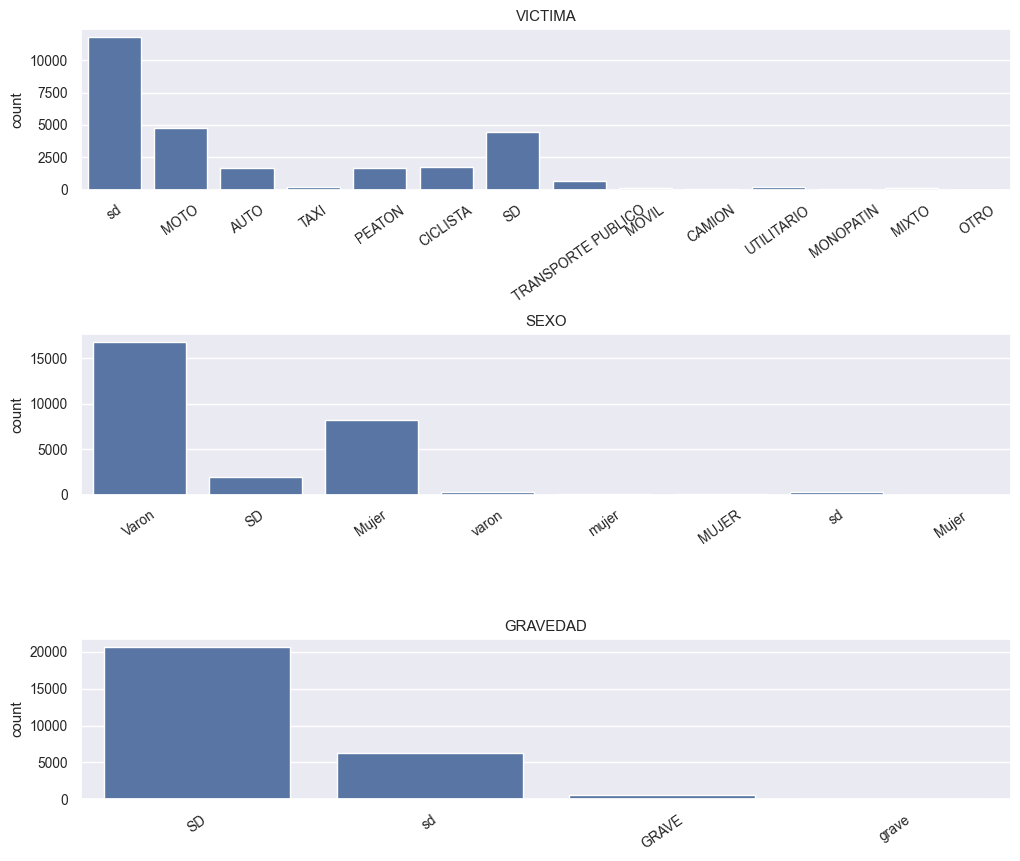

In [155]:
columnas= ['VICTIMA', 'SEXO', 'GRAVEDAD']
fig, ax = plt.subplots(nrows= 3, ncols= 1, figsize= (12,10))
fig.subplots_adjust(hspace= 0.9)
for i, col in enumerate(columnas):
    sns.countplot(data=df_victimas_lesiones, x= col, ax= ax[i])
    ax[i].set_title(col)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation= 35)

In [156]:
df_victimas_lesiones.isnull().sum()

Id_hecho    0
VICTIMA     0
SEXO        0
EDAD        0
GRAVEDAD    0
dtype: int64

No se observan valores nulos

Se transforman los valores de las variables categoricas con valores "SD" a "SIN DATO"

In [157]:
columnas= ['VICTIMA', 'SEXO', 'EDAD', 'GRAVEDAD']
for col in columnas:
    df_victimas_lesiones.loc[df_victimas_lesiones[col].isin(['sd', 'SD']), col] = 'SIN DATO'

Se Transforman todos los valores de 'SEXO' en mayusculas y minusculas a MASCULINO, FEMENINO y los valores de 'GRAVEDAD' en minusculas a mayusculas

In [158]:
df_victimas_lesiones.loc[df_victimas_lesiones['SEXO'].isin(['Varon','varon']),'SEXO'] = 'MASCULINO'
df_victimas_lesiones.loc[df_victimas_lesiones['SEXO'].isin(['Mujer','mujer', 'MUJER','Mujer ']), 'SEXO'] = 'FEMENINO'
df_victimas_lesiones.loc[df_victimas_lesiones['GRAVEDAD'] == 'grave', 'GRAVEDAD'] = 'GRAVE'

Se calculan los promedios de las edades por sexo para imputar los registros faltantes

In [159]:
Promedio_edad_M= round(df_victimas_lesiones[(df_victimas_lesiones['SEXO'] == 'MASCULINO') & (df_victimas_lesiones['EDAD'] != 'SIN DATO')]['EDAD'].astype(int).mean())
print(Promedio_edad_M)
Promedio_edad_F= round(df_victimas_lesiones[(df_victimas_lesiones['SEXO'] == 'FEMENINO') & (df_victimas_lesiones['EDAD'] != 'SIN DATO')]['EDAD'].astype(int).mean())
print(Promedio_edad_F)

37
40


Se Imputan los los valores sin datos (SD) con el promedio de edad de cada sexo

In [160]:
df_victimas_lesiones.loc[(df_victimas_lesiones['SEXO'] == 'MASCULINO') & (df_victimas_lesiones['EDAD'] == 'SIN DATO'),'EDAD'] = Promedio_edad_M
df_victimas_lesiones.loc[(df_victimas_lesiones['SEXO'] == 'FEMENIMO') & (df_victimas_lesiones['EDAD'] == 'SIN DATO'),'EDAD'] = Promedio_edad_F

In [161]:
df_victimas_lesiones['EDAD'].value_counts() # Contar los valores

EDAD
SIN DATO    2986
37          1954
29           668
28           646
30           634
            ... 
88             1
94             1
100            1
96             1
97             1
Name: count, Length: 190, dtype: int64

Aun quedan muchos registros sin datos(SD) en EDAD por no lo tanto no se pueden eliminar sin afectar el analisis

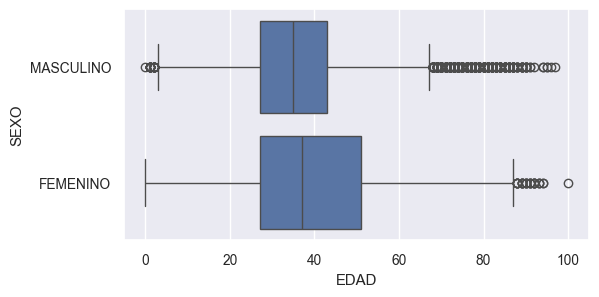

In [162]:
df_grafico= df_victimas_lesiones[(df_victimas_lesiones['SEXO'] != 'SIN DATO') & (df_victimas_lesiones['EDAD'] != 'SIN DATO')]
plt.figure(figsize= (6,3))
sns.boxplot(data=df_grafico, x=df_grafico['EDAD'].astype(int), y='SEXO')
plt.show()

En este grafico podemos observar que la mediana de las victimas lesionadas masculinos es mas o menos 37 y que la mayoria entan entre un pocos menos de 27 hasta los casi 70 años. En cambio las mediana de las victimas femeninas es un poco menos de 40 y la mayoria entan entre los 27 y los casi 90 años. Tambien se pueden ver alunos valores atipicos de edades entre los 70 y los casi 100 años en hombres y entre los casi 90 y los 100 en mujeres, pero no son outliers pues estan entre las edades normales que puede llegar a tener un ser humano

In [163]:
df_victimas_lesiones.head(3)

,Id_hecho,VICTIMA,SEXO,EDAD,GRAVEDAD
0,LC-2019-0000053,SIN DATO,MASCULINO,57,SIN DATO
1,LC-2019-0000063,SIN DATO,SIN DATO,SIN DATO,SIN DATO
2,LC-2019-0000079,SIN DATO,MASCULINO,37,SIN DATO


#### `Exportacion de Datasets a .csv`

In [164]:
df_hechos_lesiones.to_csv('data/hechos_lesiones.csv', index=False)    #Exportar df_hechos_lesiones a un archivo hechos_lesiones.cvs
df_victimas_lesiones.to_csv('data/victimas_lesiones.csv', index=False)    #Exportar df_victimas_lesiones a un archivo victimas_lesiones.cvs